In [1]:
import os
import obspy.clients.fdsn
import numpy as np
import pandas as pd
import obspy
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from datetime import datetime
import scipy
import warnings
warnings.filterwarnings("ignore")


import pylab as plt
import warnings
import os
import h5py
import matplotlib as mpl
%matplotlib inline

import sklearn
from sklearn import linear_model

import pandas as pd
import seaborn as sns

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, LSTM
from keras import losses
from keras.utils.np_utils import to_categorical
from keras.layers import BatchNormalization
import keras.backend as K

from __future__ import print_function

from collections import defaultdict
import pickle
from PIL import Image

from six.moves import range

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np

from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot

np.random.seed(42)

In [2]:
W = np.load('IRIS_dataset_waveforms.npy')
Y = np.load('IRIS_dataset_labels.npy')

In [3]:
W.shape, Y.shape

((1357, 3, 1600), (1357, 1))

In [4]:
W = W.reshape(-1,1600,3,1)
W.shape

(1357, 1600, 3, 1)

In [8]:
def build_generator(latent_size):
        # label input
        in_label = Input(shape=(1,))
        li = Embedding(100, latent_size,'glorot_normal')(in_label)
        
        n_nodes = 100*3
        li = Dense(n_nodes)(li)
        li = Reshape((100, 3, 1))(li)        
        
        in_lat = Input(shape=(latent_size,))        
        n_nodes = 384 * 100 * 3
        gen = Dense(n_nodes)(in_lat)
        gen = Activation('relu')(gen)
        gen = Reshape((100, 3, 384))(gen)
        
        # merge image gen and label input
        merge = Concatenate()([gen, li])

        gen = Conv2D(32,(5,5), activation='relu', padding='SAME')(merge)
        gen = BatchNormalization()(gen)
        gen = tf.keras.layers.UpSampling2D((2,1))(gen)
        gen = Conv2D(64,(5,5), activation='relu', padding='SAME')(gen)
        gen = BatchNormalization()(gen)
        gen = Conv2D(128,(3,3), activation='relu', padding='SAME')(gen)
        gen = BatchNormalization()(gen)
        gen = Conv2D(256,(3,3), activation='relu', padding='SAME')(gen)
        gen = BatchNormalization()(gen)
        gen = Conv2D(128,(3,3), activation='relu', padding='SAME')(gen)
        gen = BatchNormalization()(gen)
        gen = tf.keras.layers.UpSampling2D((2,1))(gen)
        gen = Conv2D(64,(3,3), activation='relu', padding='SAME')(gen)
        gen = BatchNormalization()(gen)
        gen = tf.keras.layers.UpSampling2D((2,1))(gen)
        gen = Conv2D(64,(3,3), activation='relu', padding='SAME')(gen)
        gen = BatchNormalization()(gen)
        gen = tf.keras.layers.UpSampling2D((2,1))(gen)
        gen = Conv2D(1,(3,3), activation='tanh', padding='SAME')(gen)
        out_layer = BatchNormalization()(gen)        
    
        # define model
        model = Model([in_lat, in_label], out_layer)
        print("------------------Generator Model--------------------")
        print(model.summary())
        return model


def build_discriminator():
        in_image = Input(shape=(1600,3,1))
        fe = Conv2D(32, (5,5), padding='same', activation='relu')(in_image)
        fe = BatchNormalization()(fe)
        fe = Conv2D(64, (5,5), padding='same', activation='relu')(in_image)
        fe = BatchNormalization()(fe)
        #fe = LeakyReLU(alpha=0.2)(fe)
        fe = Conv2D(128, (3,3), padding='same', activation='relu')(fe)
        fe = BatchNormalization()(fe)
        #fe = LeakyReLU(alpha=0.2)(fe)
        fe = Conv2D(256, (3,3), padding='same', activation='relu')(fe)
        fe = BatchNormalization()(fe)
        #fe = LeakyReLU(alpha=0.2)(fe)
        fe = Conv2D(128, (3,3), padding='same', activation='relu')(fe)
        fe = BatchNormalization()(fe)
        fe = Conv2D(64, (3,3), padding='same', activation='relu')(fe)
        fe = BatchNormalization()(fe)
        #fe = LeakyReLU(alpha=0.2)(fe)
        #fe = Dropout(0.5)(fe)
        fe = Flatten()(fe)
        # real/fake output
        out1 = Dense(1, activation='sigmoid')(fe)
        # class label output
        out2 = Dense(2, activation='softmax')(fe)
        # define model
        model = Model(in_image, [out1, out2])
    
        print("------------------Discriminator Model--------------------")
        print(model.summary())    
        return model

In [9]:
if __name__ == '__main__':

    nb_epochs = 20
    batch_size = 32
    latent_size = 100
    n_classes = 2

    adam_lr = 0.0002
    adam_beta_1 = 0.5

    # build the discriminator
    discriminator = build_discriminator()
    discriminator.compile(
        optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )

    # build the generator
    generator = build_generator(latent_size)
    generator.compile(optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
                      loss='binary_crossentropy')

    latent = Input(shape=(latent_size, ))
    image_class = Input(shape=(1,), dtype='int32')

    # get a fake image
    fake = generator([latent, image_class])

    # we only want to be able to train generation for the combined model
    discriminator.trainable = False
    fake, aux = discriminator(fake)
    combined = Model([latent, image_class], [fake, aux])

    combined.compile(
        optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )

    X_train, y_train,X_test, y_test = W[:1085],Y[:1085],W[1085:],Y[1085:]

    nb_train, nb_test = X_train.shape[0], X_test.shape[0]

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    for epoch in range(nb_epochs):
        print('Epoch {} of {}'.format(epoch + 1, nb_epochs))

        nb_batches = int(X_train.shape[0] / batch_size)
        progress_bar = Progbar(target=nb_batches)

        epoch_gen_loss = []
        epoch_disc_loss = []

        for index in range(nb_batches):
            progress_bar.update(index)
            # generate a new batch of noise
            noise = np.random.uniform(-1, 1, (batch_size, latent_size))

            # get a batch of real images
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            label_batch = y_train[index * batch_size:(index + 1) * batch_size]

            # sample some labels from p_c
            sampled_labels = np.random.randint(0, 2, batch_size)

            # generate a batch of fake images, using the generated labels as a
            # conditioner. We reshape the sampled labels to be
            # (batch_size, 1) so that we can feed them into the embedding
            # layer as a length one sequence
            generated_images = generator.predict(
                [noise, sampled_labels.reshape((-1, 1))], verbose=0)

            X = np.concatenate((image_batch, generated_images))
            y = np.array([1] * batch_size + [0] * batch_size)
            aux_y = np.concatenate((label_batch, sampled_labels.reshape((-1, 1))), axis=0)

            # see if the discriminator can figure itself out...
            epoch_disc_loss.append(discriminator.train_on_batch(X, [y, aux_y]))

            # make new noise. we generate 2 * batch size here such that we have
            # the generator optimize over an identical number of images as the
            # discriminator
            noise = np.random.uniform(-1, 1, (2 * batch_size, latent_size))
            sampled_labels = np.random.randint(0, 2, 2 * batch_size)

            # we want to train the genrator to trick the discriminator
            # For the generator, we want all the {fake, not-fake} labels to say
            # not-fake
            trick = np.ones(2 * batch_size)

            epoch_gen_loss.append(combined.train_on_batch(
                [noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))

        print('\nTesting for epoch {}:'.format(epoch + 1))

        # evaluate the testing loss here

        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (nb_test, latent_size))

        # sample some labels from p_c and generate images from them
        sampled_labels = np.random.randint(0, 2, nb_test)
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=False)

        X = np.concatenate((X_test, generated_images))
        y = np.array([1] * nb_test + [0] * nb_test)
        aux_y = np.concatenate((y_test, sampled_labels.reshape((-1, 1))), axis=0)

        # see if the discriminator can figure itself out...
        discriminator_test_loss = discriminator.evaluate(
            X, [y, aux_y], verbose=False)

        discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

        # make new noise
        noise = np.random.uniform(-1, 1, (2 * nb_test, latent_size))
        sampled_labels = np.random.randint(0, 2, 2 * nb_test)

        trick = np.ones(2 * nb_test)

        generator_test_loss = combined.evaluate(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels], verbose=False)

        generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

        # generate an epoch report on performance
        train_history['generator'].append(generator_train_loss)
        train_history['discriminator'].append(discriminator_train_loss)

        test_history['generator'].append(generator_test_loss)
        test_history['discriminator'].append(discriminator_test_loss)

        print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
            'component', *discriminator.metrics_names))
        print('-' * 65)

        ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
        print(ROW_FMT.format('generator (train)',
                             *train_history['generator'][-1]))
        print(ROW_FMT.format('generator (test)',
                             *test_history['generator'][-1]))
        print(ROW_FMT.format('discriminator (train)',
                             *train_history['discriminator'][-1]))
        print(ROW_FMT.format('discriminator (test)',
                             *test_history['discriminator'][-1]))

        # save weights every epoch
        generator.save_weights(
            'params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
        discriminator.save_weights(
            'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

        # generate some waveforms to display
        # generate a new batch of noise
#         noise = np.random.uniform(-1, 1, (nb_test, latent_size))
#         sampled_labels = np.random.randint(0, 2, nb_test)
#         generated_images = generator.predict(
#             [noise, sampled_labels.reshape((-1, 1))], verbose=True)
#         generated_images = generated_images.reshape(nb_test,1600,3)
        
    #saving model weights and history training and testing performance of each epoch

    pickle.dump({'train': train_history, 'test': test_history},
                open('acgan-history.pkl', 'wb'))

------------------Discriminator Model--------------------
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1600, 3, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 1600, 3, 64)  1664        ['input_11[0][0]']               
                                                                                                  
 batch_normalization_29 (BatchN  (None, 1600, 3, 64)  256        ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                  

 conv2d_37 (Conv2D)             (None, 200, 3, 256)  295168      ['batch_normalization_36[0][0]'] 
                                                                                                  
 batch_normalization_37 (BatchN  (None, 200, 3, 256)  1024       ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_38 (Conv2D)             (None, 200, 3, 128)  295040      ['batch_normalization_37[0][0]'] 
                                                                                                  
 batch_normalization_38 (BatchN  (None, 200, 3, 128)  512        ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 up_sampli

32/33 [============================>.] - ETA: 13s
Testing for epoch 12:
component              | loss | dense_8_loss    | dense_9_loss
-----------------------------------------------------------------
generator (train)      | 0.00 | 0.00            | 0.00 
generator (test)       | 4.80 | 4.80            | 0.00 
discriminator (train)  | 0.01 | 0.00            | 0.01 
discriminator (test)   | 2.06 | 1.63            | 0.43 
Epoch 13 of 20
32/33 [============================>.] - ETA: 13s
Testing for epoch 13:
component              | loss | dense_8_loss    | dense_9_loss
-----------------------------------------------------------------
generator (train)      | 0.00 | 0.00            | 0.00 
generator (test)       | 4.40 | 4.40            | 0.00 
discriminator (train)  | 0.00 | 0.00            | 0.00 
discriminator (test)   | 1.30 | 1.01            | 0.29 
Epoch 14 of 20
32/33 [============================>.] - ETA: 13s
Testing for epoch 14:
component              | loss | dense_8_loss    

In [10]:
best_epoch = 20
noise = np.random.uniform(-1, 1, (nb_test, latent_size))
sampled_labels = np.ones(nb_test)
generator.load_weights('params_generator_epoch_{0:03d}.hdf5'.format(best_epoch-1))
generated_images = generator.predict([noise, sampled_labels.reshape((-1, 1))],
                                     verbose=True)
generated_images = generated_images.reshape(nb_test,1600,3)

9/9 [==============================] - 2s 212ms/step


In [11]:
generated_images.shape, W.shape

((272, 1600, 3), (1357, 1600, 3, 1))

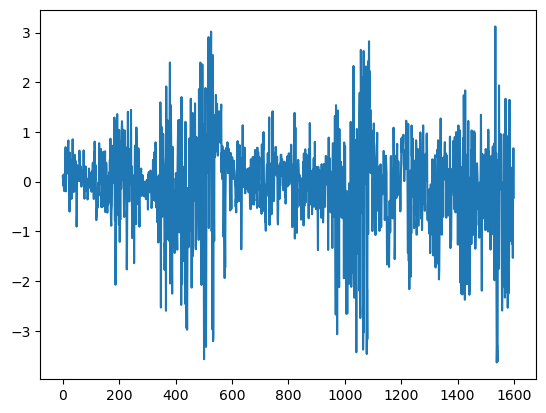

In [30]:
plt.plot(generated_images[15,:,0])

In [13]:
gen_train=[]
dis_train=[]
gen_test=[]
dis_test=[]

for i in range(len(train_history['generator'])):
    gen_train.append(train_history['generator'][i][0])
    dis_train.append(train_history['discriminator'][i][0])
    
for i in range(len(test_history['generator'])):
    gen_test.append(test_history['generator'][i][0])
    dis_test.append(test_history['discriminator'][i][0])

Text(0, 0.5, '$L_c$')

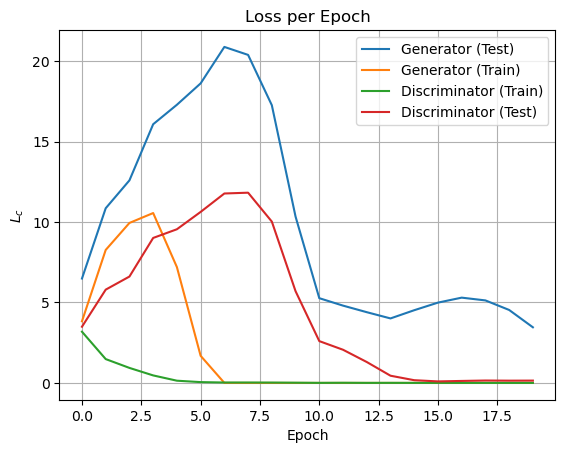

In [67]:
plt.plot(gen_test,label='Generator (Test)')
plt.plot(gen_train,label='Generator (Train)')
plt.plot(dis_train,label='Discriminator (Train)')
plt.plot(dis_test,label='Discriminator (Test)')
plt.grid()
plt.legend()
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel(r'$L_c$')

In [22]:
generated_images.shape, W.shape

((272, 1600, 3), (1357, 1600, 3, 1))

In [34]:
generated_images = generated_images.reshape(-1,1600,3,1)

In [35]:
X = np.concatenate([W,generated_images], axis=0)
X.shape

(1629, 1600, 3, 1)

In [36]:
Y.shape,sampled_labels.shape

((1357, 1), (272,))

In [37]:
sampled_labels = sampled_labels.reshape(-1,1)
y = np.concatenate([Y,sampled_labels], axis=0)
y.shape

(1629, 1)

In [38]:
seed = 42
np.random.seed(seed)
np.random.shuffle(X)
np.random.seed(seed)
np.random.shuffle(y)

In [60]:
W_test = np.load('IRIS_dataset_waveforms_test.npy')
Y_test = np.load('IRIS_dataset_labels_test.npy')
W_test.shape, Y_test.shape

((198, 3, 1600), (198, 1))

In [61]:
W_test = W_test.reshape(-1,1600,3,1)

In [62]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet34(shape = (1600, 3, 1), classes = 2):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=5, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3,3,4]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(2):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [63]:
model1 = ResNet34()
model1.compile(optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
                      loss='binary_crossentropy',
             metrics=[tf.keras.metrics.Precision()])
model1.fit(X,y,epochs=1, batch_size=32, verbose=True)

51/51 [==============================] - 158s 3s/step - loss: 1.0705 - precision_11: 0.3861


In [65]:
model2 = ResNet34()
model2.compile(optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
                      loss='binary_crossentropy',
             metrics=[tf.keras.metrics.Precision()])
model2.fit(W,Y,epochs=1, batch_size=32, verbose=True)

43/43 [==============================] - 131s 3s/step - loss: 2.9780 - precision_12: 0.2631
